In [1]:
! pip install sacrebleu sentencepiece &> /dev/null
! pip install nltk==3.2.4
! pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.1 MB/s 
  Created wheel for nltk: filename=nltk-3.2.4-py3-none-any.whl size=1367724 sha256=28e17ce3270673b96cf4fef40bc85cadfcfb6731ce56196084ea3ce97005c04a
  Stored in directory: /root/.cache/pip/wheels/90/5e/9e/4cb46185f2a16c60e6fc524372ba7fef89ce3347734c8798b6
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 362 kB 10.3 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
     |████████████████████████████████| 140 kB 72.3 MB/s 
     |████████████████████████████████| 212 kB 66.3 MB/s 
     |████████████████████████████████| 

In [2]:
!rm ita-eng.zip &> /dev/null
!rm rm -rf dataset &> /dev/null
!wget "https://www.manythings.org/anki/ita-eng.zip" &> /dev/null
!unzip "ita-eng.zip" -d "dataset" &> /dev/null

text_file = "dataset/ita.txt"

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import numpy as np
import os
import io
import time
from string import digits
import warnings; warnings.filterwarnings("ignore")

In [4]:
data_path = "dataset/ita.txt"
sample_size = 250000
EPOCHS = 5
num_of_test = 30
BATCH_SIZE = 128
embedding_dim = 512
units = 1024

In [5]:
#Read the data
lines_raw = pd.read_table(data_path,names=['source', 'target','copyright'])
lines_raw.sample(5)

,source,target,copyright
257220,I found the picture interesting.,Trovai la foto interessante.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
44068,You aren't funny.,Non sei divertente.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
142789,Tom got angry with Mary.,Tom si è arrabbiato con Mary.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
242680,He acted the part of King Lear.,Lui ha recitato la parte di Re Lear.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
38027,I'd like to help.,Vorrei aiutare.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [6]:
def preprocess_sentence(sentence):
    #sentence = unicode_to_ascii(sentence.lower().strip())
    num_digits= str.maketrans('','', digits)
    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    sentence= sentence.strip()
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    
    return sentence

In [7]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [8]:
source, target, _ = create_dataset(data_path, sample_size)

In [9]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [10]:
source_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post' )

In [11]:
target_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post' )

### Limit the size of the dataset to experiment faster (optional)

 To train faster, we can limit the size of the dataset using **sample_size** sentences (of course, translation quality degrades with less data):

In [12]:
max_target_length= max(len(t) for t in  target_tensor)
print(max_target_length)
max_source_length= max(len(t) for t in  source_tensor)
print(max_source_length)

21
13


##  Creating Train and Test dataset

In [13]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor= train_test_split(source_tensor, target_tensor,test_size=0.2)

In [14]:
BUFFER_SIZE = len(source_train_tensor)
steps_per_epoch = len(source_train_tensor)//BATCH_SIZE
vocab_inp_size = len(source_sentence_tokenizer.word_index)+1
vocab_tar_size = len(target_sentence_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 13]), TensorShape([128, 21]))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 13, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)


In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 13, 1)


In [20]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 22042)


In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [23]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [24]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [25]:
total_time = 0
import time
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  total_time = total_time + time.time() - start

print('Total time taken {} sec\n'.format(total_time))

#Telegram API
token = "5597879510:AAH1FSuZa7lA_xoAp-7JiUDE0OY38p-Tq5M"
theUrl = "https://api.telegram.org/bot"+token+"/sendMessage"
denny = "36985739"
gruppo = "-606080513"
who = denny
    
def sendMessage(text=""):
    import json
    import requests
    data = {'chat_id': who, 'disable_notification': 'false', 'text': text}
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    print(data)
    requests.post(theUrl, data=json.dumps(data, ensure_ascii=True), headers=headers)

sendMessage('GRU [20 epoche] - Total time taken {} sec\n'.format(total_time))    

Epoch 1 Batch 0 loss 3.1960318088531494
Epoch 1 Batch 100 loss 1.5377833843231201
Epoch 1 Batch 200 loss 1.384519100189209
Epoch 1 Batch 300 loss 1.3931492567062378
Epoch 1 Batch 400 loss 1.3137201070785522
Epoch 1 Batch 500 loss 1.276463270187378
Epoch 1 Batch 600 loss 1.1971609592437744
Epoch 1 Batch 700 loss 1.1932590007781982
Epoch 1 Batch 800 loss 1.155234456062317
Epoch 1 Batch 900 loss 1.0661602020263672
Epoch 1 Batch 1000 loss 1.09079909324646
Epoch 1 Batch 1100 loss 1.0205096006393433
Epoch 1 Batch 1200 loss 1.0492385625839233
Epoch 1 Batch 1300 loss 0.9756131768226624
Epoch 1 Batch 1400 loss 0.9941391944885254
Epoch 1 Batch 1500 loss 0.8741113543510437
Epoch 1 Loss 1.1756
Time taken for 1 epoch 561.9295585155487 sec

Epoch 2 Batch 0 loss 0.8887646198272705
Epoch 2 Batch 100 loss 0.8473026752471924
Epoch 2 Batch 200 loss 0.8209403157234192
Epoch 2 Batch 300 loss 0.7807292342185974
Epoch 2 Batch 400 loss 0.7485247850418091
Epoch 2 Batch 500 loss 0.7332770824432373
Epoch 2 Batch

## Evaluating the model

In [26]:
def evaluate(sentence):
  attention_plot = np.zeros((max_target_length, max_source_length))

  sentence = preprocess_sentence(sentence)
  #print(sentence)
  #print(source_sentence_tokenizer.word_index)

  inputs = []
  for i in sentence.split(' '):
      try:
        inputs.append(source_sentence_tokenizer.word_index[i])
      except:
        pass
  #inputs = [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)

  for t in range(max_target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_sentence_tokenizer.index_word[predicted_id] + ' '

    if target_sentence_tokenizer.index_word[predicted_id] == '_end':
      return result, sentence, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

## To Plot Attention weights

In [27]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [28]:
def translate(sentence, show_attention=False):
  result, sentence, attention_plot = evaluate(sentence)
  
  if show_attention:
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    
  result = result.replace("_end","")
  result = result.replace("start_","")
  return result

## Restore the latest checkpoint and test

In [29]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Final translations with Attention Plots

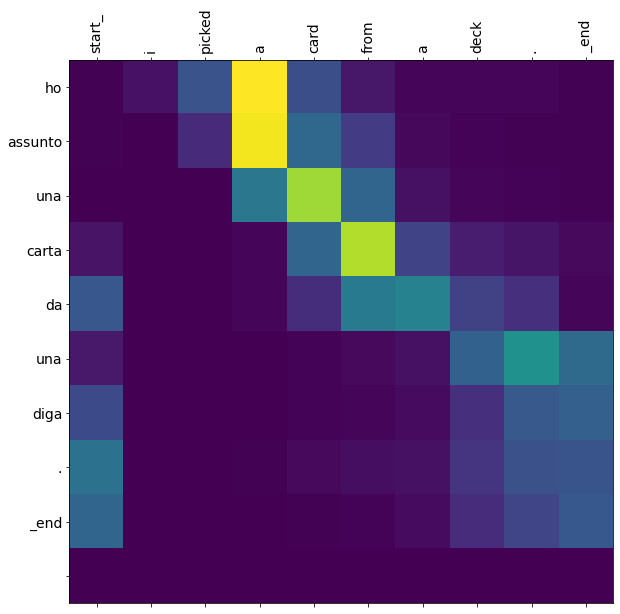

'ho assunto una carta da una diga .  '

In [30]:
translate("I picked a card from a deck.", True)

# Evaluation


In [31]:
def metric(target,output):
    import evaluate
    predictions = [output]
    references = [target]
    bleu = evaluate.load("bleu")
    try:
        results = bleu.compute(predictions=predictions, references=references)["bleu"]
    except:
        results = 0
    return results

In [32]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, ita, _ = line.split("\t")
    ita = "[start] " + ita + " [end]"
    text_pairs.append((eng, ita))

import random
random.seed(39081)
random.shuffle(text_pairs)

In [33]:
num_train_samples = int(len(text_pairs)*0.80)
train_pairs = text_pairs[:num_train_samples ]
test_pairs = text_pairs[num_train_samples:]
print("")
print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(test_pairs)} test pairs")


354238 total pairs
283390 training pairs
70848 test pairs


In [34]:
def clean(word):
    clean_word = word.lower()
    clean_word = clean_word.replace(".","")
    clean_word = clean_word.replace("\"","")
    clean_word = clean_word.replace(",","")
    clean_word = clean_word.replace("[start]","")
    clean_word = clean_word.replace("[end]","")
    clean_word = clean_word.strip()
    return clean_word

In [35]:
def calculate_metric_on_testset():
    try:
        result = 0
        count = 0
        for i,item in enumerate(test_pairs[0:100]):
            input_eng = clean(item[0])   #eng
            target = clean(item[1])  #ita
            output = clean(translate(input_eng))
            item_result = metric(target,output)

            print("=================== TEST #", i, "===================")
            print("🇮🇹 ",target)
            print("🇺🇸 ",input_eng)
            print("Translated: ",output)
            print("BLEU score: ", item_result)
            result+=item_result
            count+=1

        final_result = result/count
        return final_result
    except Exception as e:
        print(">>> Exception:", e)
        return -1

In [36]:
result = calculate_metric_on_testset()
print("\nResult:", result)
sendMessage('GRU [5 epoche] - Total time taken {} sec\n'.format(result))

=================== TEST # 0 ===================
🇮🇹  dove andrà in vacanza?
🇺🇸  where will you go for the vacation?
Translated:  dove andrai in vacanza ?
BLEU score:  0.0
=================== TEST # 1 ===================
🇮🇹  parlare inglese non è facile
🇺🇸  speaking english isn't easy
Translated:  parlare inglese non è facile
BLEU score:  1.0
=================== TEST # 2 ===================
🇮🇹  ho visto un aereo
🇺🇸  i saw a plane
Translated:  io ho visto un aereo
BLEU score:  0.668740304976422
=================== TEST # 3 ===================
🇮🇹  lui è occupato con i compiti a casa
🇺🇸  he's busy with his homework now
Translated:  è occupato con i suoi compiti
BLEU score:  0.38498150077635496
=================== TEST # 4 ===================
🇮🇹  ha due anni in meno di lui
🇺🇸  she's two years younger than him
Translated:  lei ha due anni più giovane
BLEU score:  0.0
=================== TEST # 5 ===================
🇮🇹  andrò a casa ora
🇺🇸  i'm going to go home now
Translated:  io andrò a cas